# Reinforcement Learning for solving the Traveling Salesman Problem
this notebook provides a custom Gymnasium Environment to model the Traveling Salesman Problem (TSP), along with some test runs and considerations.


<div style="text-align: right"> Monaco Filippo (Università degli Studi di Milano-Bicocca, Università degli Studi di Milano Statale) </div>

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

import gymnasium as gym
from gymnasium import spaces

from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import PPO, A2C, DQN

from python_tsp.exact import solve_tsp_dynamic_programming, solve_tsp_brute_force
from python_tsp.heuristics import solve_tsp_simulated_annealing, solve_tsp_local_search

# 📍 TSP

In [54]:
def plot_path(nodes, path, title = 'Path', draw_all = False):

    x = [point[0] for point in nodes]
    y = [point[1] for point in nodes]

    fig = plt.figure(figsize = (10,10))

    # plot nodes
    plt.scatter(x, y, 
                color = 'tab:blue', s = 30,
                zorder = 2)
    
    plt.scatter(x[path[0]], y[path[0]],
                color = 'tab:green', s = 50,
                zorder = 3)
    plt.text(x[path[0]], y[path[0]]+0.015, s = 'Start',
             ha = 'center', color = 'tab:green',
             bbox = dict(facecolor='white', edgecolor = 'tab:green', boxstyle = 'round'))
    
    plt.scatter(x[path[-1]], y[path[-1]],
                color = 'tab:red', s = 50,
                zorder = 3)
    plt.text(x[path[-1]], y[path[-1]]+0.015, s = 'End',
             ha = 'center', color = 'tab:red',
             bbox = dict(facecolor='white', edgecolor = 'tab:red', boxstyle = 'round'))
        
    # plot path
    if draw_all:
        for i in range(len(nodes) - 1):
            for j in range(i+1, len(nodes)):
                plt.plot([x[i], x[j]], [y[i], y[j]],
                         color = 'lightgrey', linestyle = '--', linewidth = 0.6,
                         zorder = 1)

    for i in range(len(path) - 1):
        start_index = path[i]
        end_index = path[i + 1]
        plt.plot([x[start_index], x[end_index]], [y[start_index], y[end_index]],
                color = 'tab:blue',
                zorder = 1)

    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()


In [55]:
# number of nodes the agent needs to visit
NUM_NODES = 10

# create nodes as random pairs of (x,y) coordinates
nodes = np.random.rand(NUM_NODES,2)

# compute distance between each point
graph = cdist(nodes,nodes)

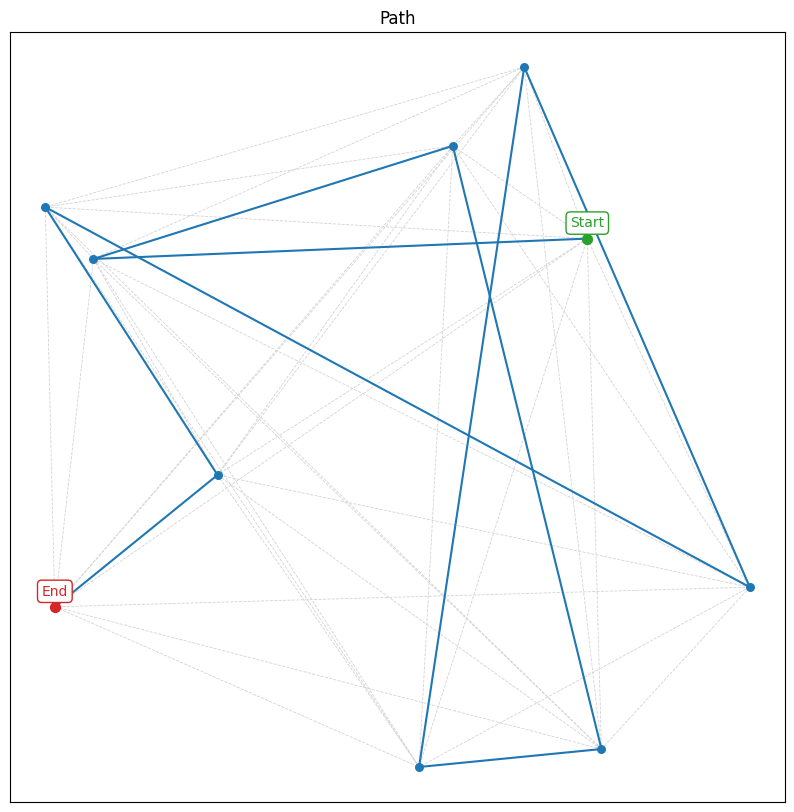

In [56]:
# plot a random route between nodes
plot_path(nodes, np.insert(np.random.permutation(len(nodes)-1)+1, 0, 0),draw_all = True)

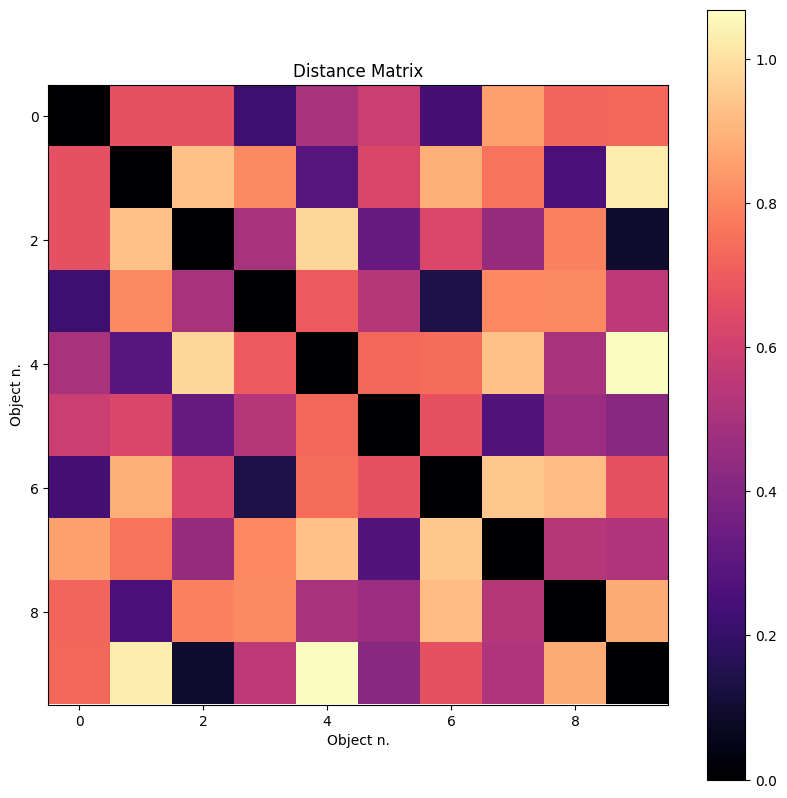

In [57]:
# plot distance matrix between points
fig = plt.figure(figsize = (10,10))
plt.imshow(graph, cmap = 'magma')
plt.title('Distance Matrix')
plt.xlabel('Object n.')
plt.ylabel('Object n.')
plt.colorbar()
plt.show()

# 🌍 Enviroment

## Definition

In [58]:
class TSPEnv(gym.Env):
    metadata = {'render_modes': ['console'], 
                'render_fps': 1}
    
    # initialize the TSP Enviroment
    def __init__(self, graph = None, render_mode = None):
        super(TSPEnv, self).__init__()
        self.render_mode = render_mode

        # graph is defined by the distance matrix between all nodes
        self.graph = graph
        if not isinstance(self.graph, np.ndarray):
            self.graph = np.array(self.graph)
        # normalize costs between 0 and 1
        self.graph = MinMaxScaler(feature_range = (0,1)).fit_transform(self.graph)
        self.graph = self.graph.astype(np.float32)
        # number of nodes is just the dimension of the distance matrix
        self.num_nodes = len(graph)

        # initialize the Agent at the first node
        self.agent_position = 0
        # initialize current neighboring connections costs
        self.neighbors = self.graph[0,:].astype(np.float32)
        # initialize visited_nodes as all unvisited
        self.visited_nodes = np.zeros(self.num_nodes, dtype = int)
        # initialize the path as empty
        self.path = []

        # initialize total cost 
        #  defined as the sum of the costs of the edges travelled so far
        self.total_cost = 0 

        # define the Observation Space
        #   what the agent can observe from the system
        self.observation_space = spaces.Dict({   
                # the node where the agent is currently at
                #   encoded as the index of the node in the graph
                'agent_position' : spaces.Discrete(self.num_nodes),

                # the list of nodes in the graph,
                #   each marked with the number of times they have been visited
                'visited_nodes': spaces.MultiDiscrete([self.num_nodes] * self.num_nodes),

                # the list of connection costs from the current node
                'neighbors': spaces.Box(low = 0.0, high = self.num_nodes-1,
                                        shape = (self.num_nodes,), dtype = np.float32)
            })
        
        # define the Action Space
        #   what Actions the Agent can perform 
        #   encoded as the next node (index) the Agent will visit
        self.action_space = spaces.Discrete(self.num_nodes)

    # translate the enviroment's state into an observation
    def _get_observation(self):
        return {
            'agent_position': int(self.agent_position),
            'visited_nodes': self.visited_nodes,
            'neighbors': self.neighbors}

    # return auxiliary information
    def _get_info(self):
        # return the sum of the costs so far
        #   and the current path through the graph
        return {
            'total_cost': self.total_cost,
            'path': self.path}

    # reset is called to initiate a new episode
    def reset(self, seed = None, options = None):
        super().reset(seed = seed)

        # set starting point on the first node of the graph
        self.agent_position = 0
        self.neighbors = self.graph[0,:]
        # set all nodes as not visited
        self.visited_nodes = np.zeros(self.num_nodes, dtype = int)

        # set the path as first node
        self.path = [0]
        # set total cost as 0
        self.total_cost = 0 

        observation = self._get_observation()
        info = self._get_info()
        return observation, info

    # the Agent performs an Action, which changes the Enviroment,
    # and it receives a Reward.
    def step(self, action):
        # update total cost accumulated
        cost = self.graph[self.agent_position, action]
        self.total_cost += cost

        # move the agent to the specified node
        self.agent_position = action

        # mark the node the agent moved to as visited
        self.visited_nodes[self.agent_position] += 1

        # add the node the agent moved to to the path
        self.path.append(self.agent_position)

        # update current neighboring costs
        self.neighbors = self.graph[self.agent_position, :]

        # episode is done if the Agent has visited the entire graph
        #   this means that the visited_nodes vector has no 0
        terminated = (0 not in self.visited_nodes)

        # stop the training early if the Agent has traversed 
        #   a number of nodes equal to X times the total
        truncated = (len(self.path) > 1*self.num_nodes-1)

        # reward function (see implementation below)
        reward = self.reward(action, cost, self.visited_nodes)

        observation = self._get_observation()
        info = self._get_info()

        return(
            observation,
            reward,
            terminated,
            truncated,
            info
        )

    # the enviroment rewards the agent in the following way:
    def reward(self, node, cost, visited):
        rew = 0

        # tuning hyperparameters
        a, b, c, d = 1, 1, 2, 10

        # punish Agent for taking connections with higher cost
        rew += -a*cost

        # if last Action brought the Agent to a new node,
        #   + b*1
        if visited[node] == 1:
            rew += b*1
        
        # if last Action brought the Agent to an already visited node,
        #   -c*(Number of Visits)
        if visited[node] > 1:
            rew += -c*visited[node]

        # if the graph has been completed (there are no 0s in visited),
        #   +d*1
        if 0 not in visited:
            rew += d*1

        return rew

    # rendering of the system
    def render(self):
        # the episode is represented as the current path through the graph
        #   and the associated total cost
        if len(self.path) == 2:
            print(0, end = '')
        if self.render_mode == 'console':
            print(f' -> {self.path[-1]}', end = '')

    def close(self):
        pass

In [131]:
# custom CallBack
class CustomCallback(BaseCallback):
    def __init__(self, env, verbose = False):
        super(CustomCallback, self).__init__(verbose)

        self.env = copy.deepcopy(env)
        self.log_dir = None
        
        self.cum_rewards = []
        self.timesteps_tested = []

    def _on_rollout_start(self) -> None:
        self.path_save_dir = f'{time.time()}'
        if not os.path.exists(self.path_save_dir):
            os.makedirs(self.path_save_dir)
    
    def _on_step(self) -> bool:
        tmp_cum_rewards = []

        done = False
        obs = self.env.reset()
        cum_rew = 0

        while not done:
            action, _ = self.model.predict(obs, deterministic = True)
            obs, rew, done, info = self.env.step(action)
            cum_rew += rew

        tmp_cum_rewards.append(cum_rew)

        self.cum_rewards.append(np.mean(tmp_cum_rewards))
        self.timesteps_tested.append(self.num_timesteps)

        plt.plot(self.timesteps_tested, self.cum_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')
        plt.grid()
        plt.savefig(f'{self.path_save_dir}/cum_reward.png')
        plt.close('all')

        return True

## Testing

Test whether the enviroment works by generating a random graph

In [76]:
# generate random graph
NUM_NODES = 5
nodes = np.random.rand(NUM_NODES,2)
graph = cdist(nodes,nodes)

env = TSPEnv(graph, render_mode = 'console')

In [77]:
# check whether the Enviroment correctly adapts the Gymnasium interface
check_env(env, warn = True)

In [72]:
# do a trial run

# reset the enviroment
obs, info = env.reset()

# check enviroment variables
print(f'observation:\t{env.observation_space}')
print(f'info:\t\t{info}')
print(f'action_space:\t{env.action_space}')

print('-'*100)

# iterate until either terminated or truncated are True
terminated, truncated = False, False
cumreward = 0
rewards = []
while not terminated and not truncated:
    # sample an Action
    action = env.action_space.sample()
    # Agent performs Action
    obs, reward, terminated, truncated, info = env.step(action)

    # update the cumulative reward
    cumreward += reward

    # render the enviroment
    env.render()

# print results
print()
print(f'Done!\t({"Terminated" if terminated else "Truncated"})')
print(f'Path:\t({len(info["path"])}){info["path"]}')
print(f'Cost:\t{info["total_cost"]}')
print(f'Reward:\t{cumreward}')

observation:	Dict('agent_position': Discrete(5), 'neighbors': Box(0.0, 4.0, (5,), float32), 'visited_nodes': MultiDiscrete([5 5 5 5 5]))
info:		{'total_cost': 0, 'path': [0]}
action_space:	Discrete(5)
----------------------------------------------------------------------------------------------------
0 -> 1 -> 4 -> 3 -> 3
Done!	(Truncated)
Path:	(5)[0, 1, 4, 3, 3]
Cost:	1.74128820002079
Reward:	-2.74128820002079


# 🧠 Reinforcement Learning

In [132]:
# Instantiate the TSP Enviroment
# generate random graph
NUM_NODES = 10
nodes = np.random.rand(NUM_NODES,2)
graph = cdist(nodes,nodes)

# create log directory
log_dir = '/tmp/gym/'
os.makedirs(log_dir, exist_ok = True)

# create and wrap the environment
vec_env = make_vec_env(TSPEnv, n_envs = 1, 
                       env_kwargs = dict({'graph':graph,
                                          'render_mode': 'console'}))

# create callback
callback = CustomCallback(env = vec_env)

## PPO

In [133]:
# PPO Model Hyperparameters
LR = 0.0003
ITERATIONS = 100000
POLICY = dict(net_arch = dict(pi = [NUM_NODES, NUM_NODES], vf = [NUM_NODES, NUM_NODES]))

PPOmodel = PPO('MultiInputPolicy',
                env = vec_env,
                learning_rate = LR,
                gamma = 0.99,
                policy_kwargs = POLICY,
                verbose = False).learn(ITERATIONS, callback = callback)

## A2C

In [12]:
# # A2C Model Hyperparameters
# ITERATIONS = 100000
# POLICY = dict(net_arch =[NUM_NODES, NUM_NODES])

# A2Cmodel = A2C('MultiInputPolicy', vec_env, policy_kwargs = POLICY, verbose = False).learn(ITERATIONS)

# 📈 Testing
Test Reinforcement Learning model and Classical Heuristics

## Reinforcement Learning

In [128]:
# Test the trained agent

# reset the enviroment
obs = vec_env.reset()

# iterate until either terminated or truncated are True
cumreward = 0
rewards = []
done = False
while not done:
    # sample an Action based on the model training
    action, _ = PPOmodel.predict(obs, deterministic = True)
    # Agent performs Action
    obs, reward, done, info = vec_env.step(action)

    # update the cumulative reward
    cumreward += reward[0]

    # render the enviroment
    # env.render()

# print results
print(f'Path:\t{info[0]["path"]}')
print(f'Cost:\t{info[0]["total_cost"]:.2f}')
print(f'Reward:\t{cumreward:.2f}')

Path:	[0, 9, 5, 8, 0, 3, 4, 1, 7, 2]
Cost:	3.59
Reward:	5.41


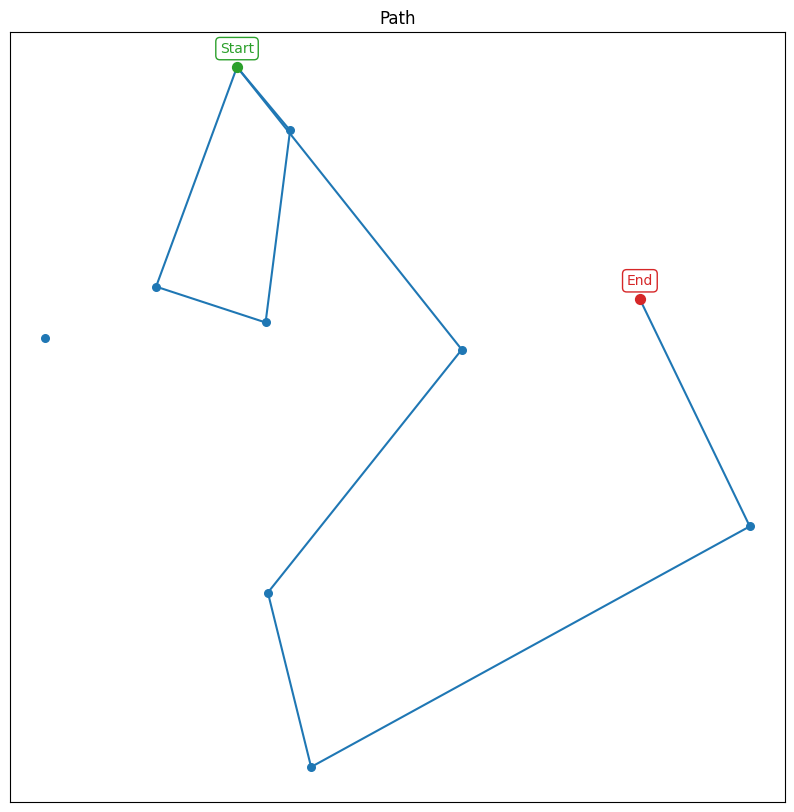

In [129]:
plot_path(nodes, info[0]["path"], draw_all = False)

In [87]:
# solve the same problems NUM times to see distribution of results
NUM = 10000
obs = vec_env.reset()
costs = []
acceptable = 0
for i in range(NUM):
    cumreward = 0
    done = False
    while not done:
        action, _ = PPOmodel.predict(obs, deterministic = False)
        obs, reward, done, info = vec_env.step(action)

        cumreward += reward
    cost = info[0]["total_cost"]
    costs.append(cost)
    if len(np.unique(info[0]["path"])) == NUM_NODES:
        acceptable += 1

min: 1.9865933507680893
avg: 4.013326070170105
max: 6.398041680455208

acc: 3.5(350)


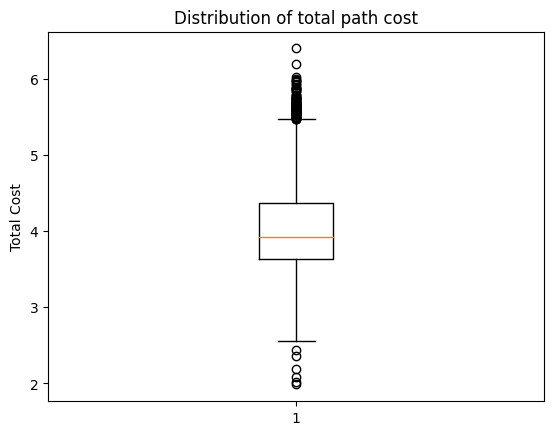

In [88]:
plt.boxplot(costs)
plt.ylabel('Total Cost')
plt.title('Distribution of total path cost')
plt.plot()

print(f'min: {np.min(costs)}')
print(f'avg: {np.mean(costs)}')
print(f'max: {np.max(costs)}')
print()
print(f'acc: {100*acceptable/NUM}({acceptable})')

## Classical Heuristics

In [ ]:
# solve_tsp_brute_force
# solve_tsp_dynamic_programming

# solve_tsp_simulated_annealing
# solve_tsp_local_search

perm, dist = solve_tsp_brute_force(graph)

# print results
print(f'Path:\t{perm}')
print(f'Cost:\t{dist:.2f}')

Path:	[0, 5, 1, 9, 8, 4, 6, 2, 7, 3]
Cost:	2.76


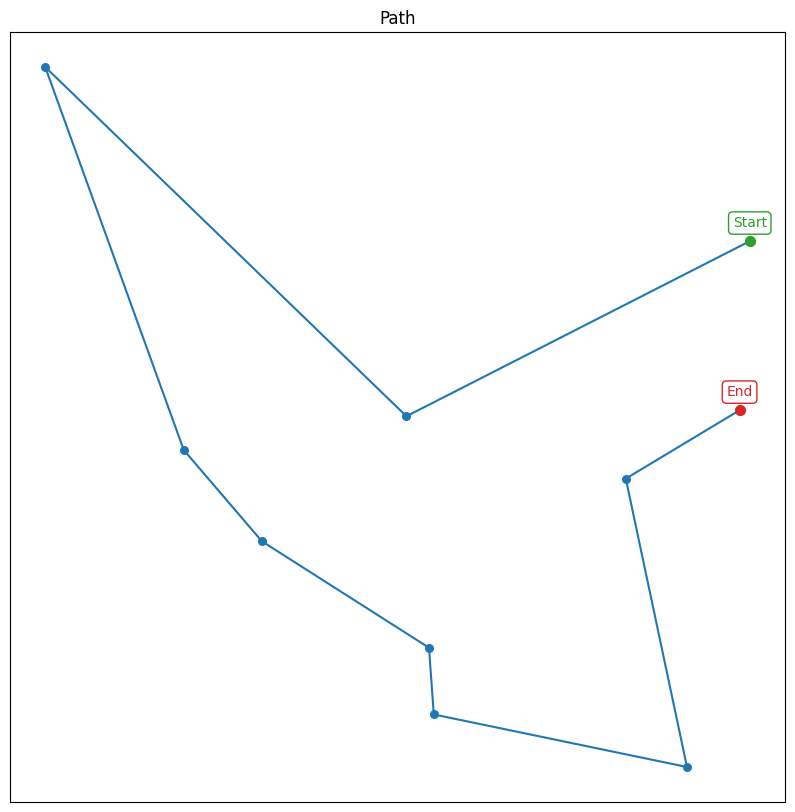

In [ ]:
plot_path(nodes, perm, draw_all = False)

## Scalability

test how the RL model performs when increasing problem size

In [ ]:
NODES = 50
LR = 0.0003
ITERATIONS = 100000

RLcosts = []
RLtimes = []
CLcosts = []
CLtimes = []
BFcosts = []
BFtimes = []

for i in range(5, NODES+1):
    NUM_NODES = i
    nodes = np.random.rand(NUM_NODES,2)
    graph = cdist(nodes,nodes)

    vec_env = make_vec_env(TSPEnv, n_envs = 1, 
                        env_kwargs = dict({'graph':graph,
                                            'render_mode': None}))

    RLt = time.time()
    POLICY = dict(net_arch = dict(pi = [NUM_NODES, NUM_NODES], vf = [NUM_NODES, NUM_NODES]))
    PPOmodel = PPO('MultiInputPolicy',
                    env = vec_env,
                    learning_rate = LR,
                    gamma = 0.99,
                    policy_kwargs = POLICY,
                    verbose = False).learn(ITERATIONS)
    
    obs = vec_env.reset()

    cumreward = 0
    done = False
    while not done:
        action, _ = PPOmodel.predict(obs, deterministic = True)
        obs, reward, done, info = vec_env.step(action)

        cumreward += reward

    RLt = time.time()-RLt
    RLtimes.append(RLt)
    RLcosts.append(info[0]['total_cost'])

    CLt = time.time()
    _, CLcost = solve_tsp_local_search(graph)
    CLt = time.time()-CLt
    CLtimes.append(CLt)
    CLcosts.append(CLcost)

    if i < 15: # 15 takes about 2 days to complete, don't go any higher
        BFt = time.time()
        _, BFcost = solve_tsp_brute_force(graph)
        BFcosts.append(BFcost)
        BFt = time.time()-BFt
        BFtimes.append(BFt)

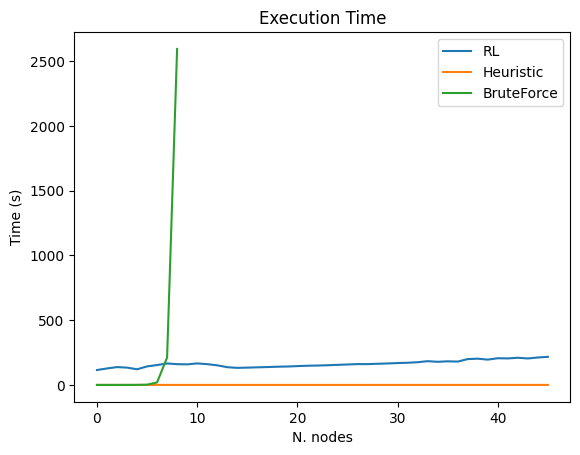

In [ ]:
# plt.plot(RLcosts, label = 'RL costs')
plt.plot(RLtimes, label = 'RL')
# plt.plot(CLcosts, label = 'CL costs')
plt.plot(CLtimes, label = 'Heuristic')
plt.plot(BFtimes[:9], label = 'BruteForce')
plt.xlabel('N. nodes')
plt.ylabel('Time (s)')
plt.title('Execution Time')
plt.legend()
plt.show()

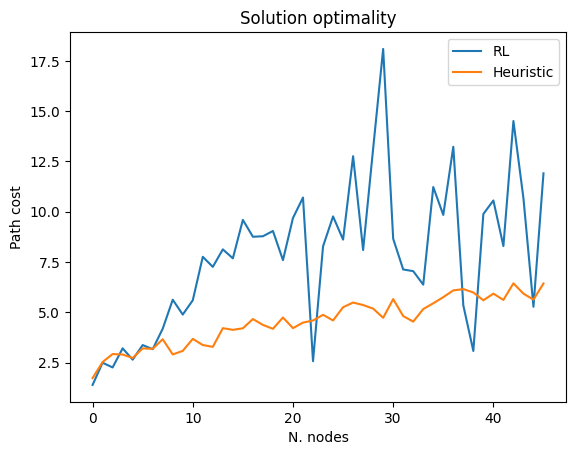

In [ ]:
plt.plot(RLcosts, label = 'RL')
plt.plot(CLcosts, label = 'Heuristic')
# plt.plot(BFcosts, label = 'BruteForce')
plt.xlabel('N. nodes')
plt.ylabel('Path cost')
plt.title('Solution optimality')
plt.legend()
plt.show()